#Fábrica de Cookie

In [ ]:
!pip install simpy
import simpy
import numpy as np
import random
from metricas import MetricasSimulacao

In [ ]:
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    RED = '\033[91m'
    WHITE = '\033[97m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'

TEMPO_SIMULACAO = 50

#Tempo de preparo universal


In [ ]:
def tempo_preparo_criacao():
  tempo_preparo = np.random.normal(loc=5, scale=1.2)
  tempo_preparo = max(1, tempo_preparo)
  return tempo_preparo

#Arquitetura 1 - fila única e múltiplos Fornos

In [ ]:
# False = livre
fornos_status = [False, False, False, False]
fornos_quebrados = [False, False, False, False]

CHANCE_FALHA = 0.1  # 2% de chance


def resetar_fornos():
    """Reseta tudo para permitir várias simulações."""
    global fornos_status, fornos_quebrados
    fornos_status = [False, False, False, False]
    fornos_quebrados = [False, False, False, False]


def tentar_falhar_forno(env, forno_id):
    """Aplica chance de falha no forno escolhido."""
    if not fornos_quebrados[forno_id] and random.random() < CHANCE_FALHA:
        fornos_quebrados[forno_id] = True
        fornos_status[forno_id] = False  # não pode mais ser ocupado
        print(f"{bcolors.FAIL}[{env.now:6.2f}] ⚠️ FORNO {forno_id} FALHOU e está fora de operação!{bcolors.ENDC}")
        return True
    return False


def pegar_forno_livre(env):
    """Retorna índice do forno livre e marca como ocupado."""

    for i, ocupado in enumerate(fornos_status):

        if fornos_quebrados[i]:
            continue  # Ignora fornos quebrados

        if not ocupado:
            if tentar_falhar_forno(env, i):
                continue  # forno falhou na hora

            # Ocupa o forno
            fornos_status[i] = True
            total_disponiveis = len([f for f in fornos_quebrados if not f])
            print(f"{bcolors.RED}[{env.now:6.2f}] → FORNO {i} ocupado — total ocupados: {sum(fornos_status)}/{total_disponiveis}")
            return i

    print(f"{bcolors.FAIL}[{env.now:6.2f}] ERRO: Nenhum forno disponível (todos ocupados ou quebrados).{bcolors.ENDC}")
    return None


def liberar_forno(env, i):
    if i is None:
        print(f"{bcolors.FAIL}Tentou liberar forno None — ignorado.{bcolors.ENDC}")
        return

    if fornos_quebrados[i]:
        print(f"{bcolors.WARNING}[{env.now:6.2f}] Forno {i} está quebrado — não pode ser liberado.{bcolors.ENDC}")
        return

    fornos_status[i] = False
    total_disponiveis = len([f for f in fornos_quebrados if not f])
    print(f"{bcolors.RED}[{env.now:6.2f}] → FORNO {i} liberado — total ocupados: {sum(fornos_status)}/{total_disponiveis}")


def processar_cookie_1(env, fornos_mutex, nome_do_lote, tempo_de_preparo):

    # Tempo até a chegada
    yield env.timeout(tempo_de_preparo)

    print(f"{bcolors.OKCYAN}[{env.now:3.3f}] Lote {nome_do_lote} chegou{bcolors.ENDC}")

    with fornos_mutex.request() as req:
        yield req

        forno_id = pegar_forno_livre(env)

        if forno_id is None:
            print(f"{bcolors.FAIL}[{env.now:3.3f}] ERRO: Nenhum forno disponível — lote abortado.{bcolors.ENDC}")
            return

        print(f"{bcolors.WHITE}[{env.now:3.3f}] Lote {nome_do_lote} entrou no FORNO {forno_id}")

        yield env.timeout(tempo_de_preparo)

        print(f"{bcolors.OKGREEN}[{env.now:3.3f}] 🍪 Lote {nome_do_lote} saiu do FORNO {forno_id}{bcolors.ENDC}")

        if forno_id is not None:
            liberar_forno(env, forno_id)
        else:
            print(f"{bcolors.FAIL}[{env.now:3.3f}] ERRO: forno_id None — nada para liberar.{bcolors.ENDC}")


In [ ]:
def gerar_lotes_1(env, fornos_mutex):
    lote_id = 0
    media_intervalo_chegada = 2.5
    lambd = 1.0 / media_intervalo_chegada

    while True:
        lote_id += 1
        tempo_preparo = tempo_preparo_criacao()

        env.process(processar_cookie_1(env, fornos_mutex, f"L{lote_id}", tempo_preparo))

        # distribuição exponencial para chegadas
        yield env.timeout(random.expovariate(lambd))

In [ ]:
resetar_fornos()

In [ ]:
env = simpy.Environment()

# 4 FORNOS
fornos_mutex = simpy.Resource(env, capacity=1)

env.process(gerar_lotes_1(env, fornos_mutex))
env.run(until=TEMPO_SIMULACAO)


[5.497] Lote L2 chegou
[  5.50] → FORNO 0 ocupado — total ocupados: 1/4
[5.497] Lote L2 entrou no FORNO 0
[6.157] Lote L1 chegou
[8.538] Lote L4 chegou
[9.131] 🍪 Lote L2 saiu do FORNO 0
[  9.13] → FORNO 0 liberado — total ocupados: 0/4
[  9.13] → FORNO 0 ocupado — total ocupados: 1/4
[9.131] Lote L1 entrou no FORNO 0
[11.235] Lote L3 chegou
[15.289] 🍪 Lote L1 saiu do FORNO 0
[ 15.29] → FORNO 0 liberado — total ocupados: 0/4
[ 15.29] → FORNO 0 ocupado — total ocupados: 1/4
[15.289] Lote L4 entrou no FORNO 0
[17.389] Lote L5 chegou
[20.026] Lote L6 chegou
[20.531] 🍪 Lote L4 saiu do FORNO 0
[ 20.53] → FORNO 0 liberado — total ocupados: 0/4
[ 20.53] ⚠️ FORNO 0 FALHOU e está fora de operação!
[ 20.53] → FORNO 1 ocupado — total ocupados: 1/3
[20.531] Lote L3 entrou no FORNO 1
[22.637] Lote L7 chegou
[24.275] Lote L8 chegou
[28.781] 🍪 Lote L3 saiu do FORNO 1
[ 28.78] → FORNO 1 liberado — total ocupados: 0/3
[ 28.78] → FORNO 1 ocupado — total ocupados: 1/3
[28.781] Lote L5 entrou no FORNO 1
[2

# Arquitetura 2 - múltiplas filas, múltiplos fornos.

In [ ]:
fornos_ocupados = 0
total_fornos = 4
uso_forno_2 = []


In [ ]:
def ocupar_forno(env, forno_id):
    global fornos_ocupados
    fornos_ocupados += 1
    uso_forno_2.append((env.now, fornos_ocupados))

    print(
        f"{bcolors.RED}[{env.now:6.2f}] → FORNO {forno_id} ocupado — total ocupados: {fornos_ocupados}/{total_fornos}{bcolors.ENDC}"
    )


def liberar_forno(env, forno_id):
    global fornos_ocupados
    fornos_ocupados -= 1
    uso_forno_2.append((env.now, fornos_ocupados))

    print(
        f"{bcolors.RED}[{env.now:6.2f}] → FORNO {forno_id} liberado — total ocupados: {fornos_ocupados}/{total_fornos}{bcolors.ENDC}"
    )


In [ ]:
def processar_cookie_2(env, forno, nome_do_lote, tempo_de_preparo, forno_id):
    yield env.timeout(tempo_de_preparo)

    # Chegada
    if forno.count == forno.capacity:
        print(f"{bcolors.WARNING}[{env.now:3.3f}] Lote {nome_do_lote} ENTROU na FILA do forno {forno_id}{bcolors.ENDC}")
    else:
        print(f"{bcolors.OKCYAN}[{env.now:3.3f}] Lote {nome_do_lote} chegou e o forno {forno_id} está LIVRE{bcolors.ENDC}")

    req = forno.request()
    yield req

    # 🔥 forno ocupado
    ocupar_forno(env, forno_id)

    print(f"[{env.now:3.3f}] Lote {nome_do_lote} entrou no FORNO {forno_id}")

    yield env.timeout(tempo_de_preparo)

    print(f"{bcolors.OKGREEN}[{env.now:3.3f}] 🍪 Lote {nome_do_lote} saiu do FORNO {forno_id}{bcolors.ENDC}")

    # 🔥 forno liberado
    liberar_forno(env, forno_id)

    forno.release(req)


In [ ]:
def gerar_lotes_2(env, fornos):
    lote_id = 0
    media_intervalo_chegada = 2.5
    lambd = 1.0 / media_intervalo_chegada

    while True:
        lote_id += 1
        tempo_preparo = tempo_preparo_criacao()

        # escolha do forno (menor fila)
        filas = [f.queue for f in fornos]
        forno_escolhido = min(range(len(fornos)), key=lambda i: len(filas[i]))


        env.process(
            processar_cookie_2(
                env,
                fornos[forno_escolhido],
                f"L{lote_id}",
                tempo_preparo,
                forno_escolhido
            )
        )

        # APLICAÇÃO DA DISTRIBUIÇÃO PROBABILÍSTICA (EXPONENCIAL)
        yield env.timeout(random.expovariate(lambd))

In [ ]:
env = simpy.Environment()

# 4 fornos → 4 filas distintas
fornos = [simpy.Resource(env, capacity=1) for _ in range(4)]

env.process(gerar_lotes_2(env, fornos))

env.run(until=50)


[5.372] Lote L1 chegou e o forno 0 está LIVRE
[  5.37] → FORNO 0 ocupado — total ocupados: 1/4
[5.372] Lote L1 entrou no FORNO 0
[5.729] Lote L4 ENTROU na FILA do forno 0
[5.874] Lote L3 ENTROU na FILA do forno 0
[7.693] Lote L2 ENTROU na FILA do forno 0
[10.711] Lote L5 chegou e o forno 1 está LIVRE
[ 10.71] → FORNO 1 ocupado — total ocupados: 2/4
[10.711] Lote L5 entrou no FORNO 1
[10.744] 🍪 Lote L1 saiu do FORNO 0
[ 10.74] → FORNO 0 liberado — total ocupados: 1/4
[ 10.74] → FORNO 0 ocupado — total ocupados: 2/4
[10.744] Lote L4 entrou no FORNO 0
[14.349] 🍪 Lote L4 saiu do FORNO 0
[ 14.35] → FORNO 0 liberado — total ocupados: 1/4
[ 14.35] → FORNO 0 ocupado — total ocupados: 2/4
[14.349] Lote L3 entrou no FORNO 0
[15.560] 🍪 Lote L5 saiu do FORNO 1
[ 15.56] → FORNO 1 liberado — total ocupados: 1/4
[17.449] Lote L7 chegou e o forno 1 está LIVRE
[ 17.45] → FORNO 1 ocupado — total ocupados: 2/4
[17.449] Lote L7 entrou no FORNO 1
[18.000] Lote L6 ENTROU na FILA do forno 1
[18.443] 🍪 Lote L

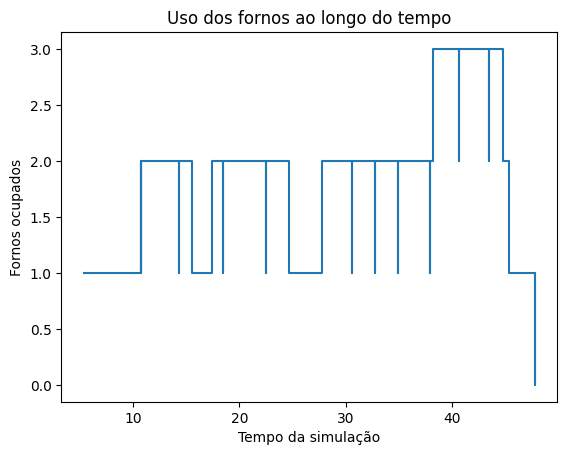

In [ ]:
tempos = [t for (t,u) in uso_forno_2]
ocupados = [u for (t,u) in uso_forno_2]

plt.step(tempos, ocupados, where="post")
plt.xlabel("Tempo da simulação")
plt.ylabel("Fornos ocupados")
plt.title("Uso dos fornos ao longo do tempo")
plt.show()


# Arquitetura 3 - múltiplas filas e um forno

In [ ]:
def processar_cookie_3(env, forno, nome_do_lote, tempo_de_preparo, forno_id):
    # tempo forno
    yield env.timeout(tempo_de_preparo)

    # se o forno estiver ocupado → fila
    if forno.count == forno.capacity:
        print(f"{bcolors.WARNING}[{env.now:3.3f}] Lote {nome_do_lote} ENTROU na FILA do forno {forno_id}{bcolors.ENDC}")
    else:
        print(f"{bcolors.OKCYAN}[{env.now:3.3f}] Lote {nome_do_lote} chegou e o forno {forno_id} está LIVRE{bcolors.ENDC}")

    req = forno.request()
    yield req

    print(f"[{env.now:3.3f}] Lote {nome_do_lote} entrou no FORNO {forno_id}")

    yield env.timeout(tempo_de_preparo)

    print(f"{bcolors.OKGREEN}[{env.now:3.3f}] 🍪 Lote {nome_do_lote} saiu do FORNO {forno_id}{bcolors.ENDC}")

    forno.release(req)


In [ ]:
def gerar_lotes_3(env, fornos):
    lote_id = 0

    media_intervalo_chegada = 2.5
    lambd = 1.0 / media_intervalo_chegada

    while True:
        lote_id += 1
        tempo_preparo =  tempo_preparo_criacao()

        env.process(
            processar_cookie_3(
                env,
                fornos[0],
                f"L{lote_id}",
                tempo_preparo,
                0
            )
        )

        # APLICAÇÃO DA DISTRIBUIÇÃO PROBABILÍSTICA (EXPONENCIAL)
        yield env.timeout(random.expovariate(lambd))


In [ ]:
env = simpy.Environment()

# 1 fornos
fornos = [simpy.Resource(env, capacity=1) for _ in range(1)]

env.process(gerar_lotes_3(env, fornos))

env.run(until=50)


[4.203] Lote L1 chegou e o forno 0 está LIVRE
[4.203] Lote L1 entrou no FORNO 0
[8.407] 🍪 Lote L1 saiu do FORNO 0
[15.733] Lote L3 chegou e o forno 0 está LIVRE
[15.733] Lote L3 entrou no FORNO 0
[17.235] Lote L5 ENTROU na FILA do forno 0
[17.731] Lote L2 ENTROU na FILA do forno 0
[18.468] Lote L4 ENTROU na FILA do forno 0
[19.809] 🍪 Lote L3 saiu do FORNO 0
[19.809] Lote L5 entrou no FORNO 0
[21.911] Lote L6 ENTROU na FILA do forno 0
[21.937] Lote L8 ENTROU na FILA do forno 0
[22.693] 🍪 Lote L5 saiu do FORNO 0
[22.693] Lote L2 entrou no FORNO 0
[23.744] Lote L7 ENTROU na FILA do forno 0
[26.094] Lote L11 ENTROU na FILA do forno 0
[26.219] Lote L9 ENTROU na FILA do forno 0
[28.264] Lote L10 ENTROU na FILA do forno 0
[29.061] Lote L14 ENTROU na FILA do forno 0
[29.856] 🍪 Lote L2 saiu do FORNO 0
[29.856] Lote L4 entrou no FORNO 0
[30.241] Lote L12 ENTROU na FILA do forno 0
[32.523] Lote L13 ENTROU na FILA do forno 0
[34.822] 🍪 Lote L4 saiu do FORNO 0
[34.822] Lote L6 entrou no FORNO 0
[39

#Análises


📊 --- Métricas: Arquitetura 1 - Fila Única, Múltiplos Fornos ---
Total de lotes processados: 16
Tempo médio na fila: 4.50
Tempo médio no sistema: 9.00
Throughput (lotes/min): 0.320
Utilização dos fornos (%): [132.0, 100.0, 44.0, 12.0]


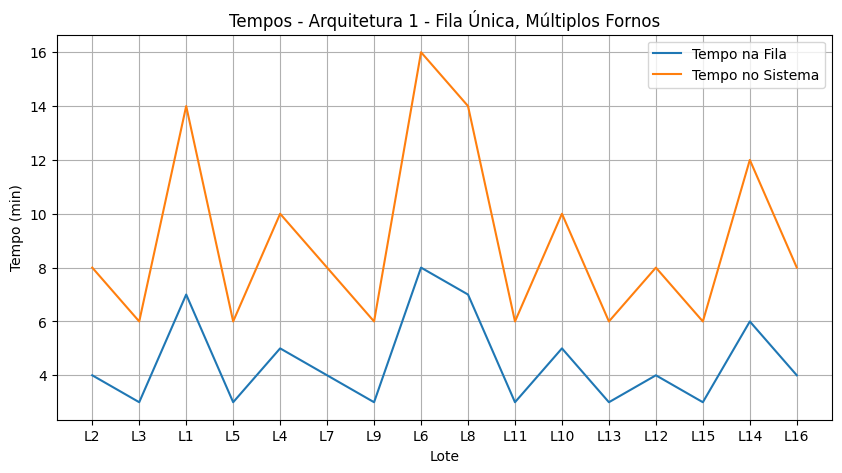

In [ ]:
# === Arquitetura 1 ===
metricas1 = MetricasSimulacao("Arquitetura 1 - Fila Única, Múltiplos Fornos")

fornos_status = [False, False, False, False]
def pegar_forno_livre():
    for i, ocupado in enumerate(fornos_status):
        if not ocupado:
            fornos_status[i] = True
            return i
    return None
def liberar_forno(i): fornos_status[i] = False

def processar_cookie_1(env, fornos, nome_do_lote, tempo_de_preparo):
    chegada = env.now
    yield env.timeout(tempo_de_preparo)
    req = fornos.request()
    yield req
    forno_id = pegar_forno_livre()
    entrada = env.now
    yield env.timeout(tempo_de_preparo)
    saida = env.now
    liberar_forno(forno_id)
    fornos.release(req)
    metricas1.registrar_evento(nome_do_lote, chegada, entrada, saida, forno_id)

def gerar_lotes_1(env, fornos):
    lote_id = 0
    while True:
        lote_id += 1
        tempo_preparo = random.randint(3, 8)
        env.process(processar_cookie_1(env, fornos, f"L{lote_id}", tempo_preparo))
        yield env.timeout(random.randint(1, 4))

env = simpy.Environment()
fornos = simpy.Resource(env, capacity=4)
env.process(gerar_lotes_1(env, fornos))
env.run(until=TEMPO_SIMULACAO)
df1 = metricas1.resumo(TEMPO_SIMULACAO)
metricas1.plotar_graficos()



📊 --- Métricas: Arquitetura 2 - Múltiplas Filas, Múltiplos Fornos ---
Total de lotes processados: 14
Tempo médio na fila: 8.86
Tempo médio no sistema: 14.29
Throughput (lotes/min): 0.280
Utilização dos fornos (%): [174.0, 138.0, 88.0]


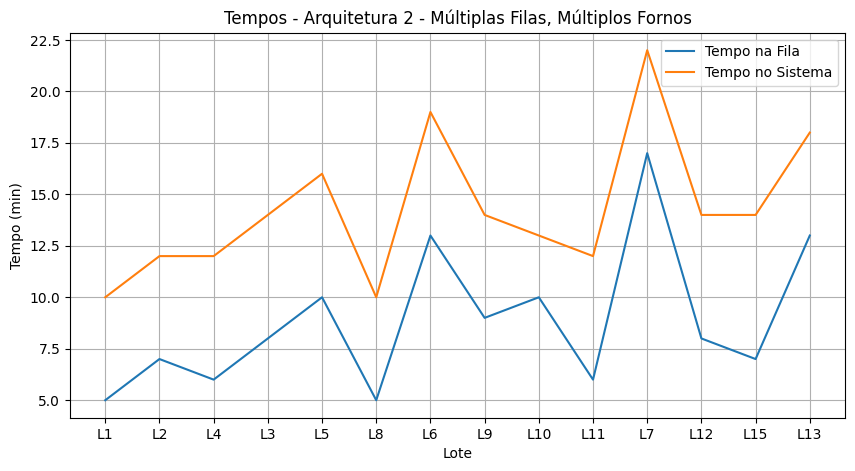

In [ ]:
# === Arquitetura 2 ===
metricas2 = MetricasSimulacao("Arquitetura 2 - Múltiplas Filas, Múltiplos Fornos")

def processar_cookie_2(env, forno, nome_do_lote, tempo_de_preparo, forno_id):
    chegada = env.now
    yield env.timeout(tempo_de_preparo)
    req = forno.request()
    yield req
    entrada = env.now
    yield env.timeout(tempo_de_preparo)
    saida = env.now
    forno.release(req)
    metricas2.registrar_evento(nome_do_lote, chegada, entrada, saida, forno_id)

def gerar_lotes_2(env, fornos):
    lote_id = 0
    while True:
        lote_id += 1
        tempo_preparo = random.randint(3, 8)
        filas = [f.queue for f in fornos]
        forno_escolhido = min(range(len(fornos)), key=lambda i: len(filas[i]))
        env.process(processar_cookie_2(env, fornos[forno_escolhido], f"L{lote_id}", tempo_preparo, forno_escolhido))
        yield env.timeout(random.randint(1, 4))

env = simpy.Environment()
fornos = [simpy.Resource(env, capacity=1) for _ in range(4)]
env.process(gerar_lotes_2(env, fornos))
env.run(until=TEMPO_SIMULACAO)
df2 = metricas2.resumo(TEMPO_SIMULACAO)
metricas2.plotar_graficos()



📊 --- Métricas: Arquitetura 3 - Múltiplas Filas, Um Forno ---
Total de lotes processados: 7
Tempo médio na fila: 16.00
Tempo médio no sistema: 21.86
Throughput (lotes/min): 0.140
Utilização dos fornos (%): [306.0]


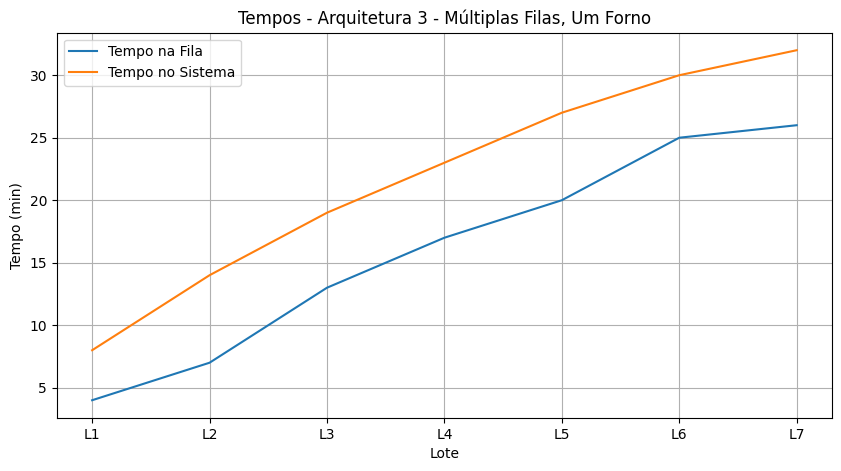

In [ ]:
# === Arquitetura 3 ===
metricas3 = MetricasSimulacao("Arquitetura 3 - Múltiplas Filas, Um Forno")

def processar_cookie_3(env, forno, nome_do_lote, tempo_de_preparo, forno_id):
    chegada = env.now
    yield env.timeout(tempo_de_preparo)
    req = forno.request()
    yield req
    entrada = env.now
    yield env.timeout(tempo_de_preparo)
    saida = env.now
    forno.release(req)
    metricas3.registrar_evento(nome_do_lote, chegada, entrada, saida, forno_id)

def gerar_lotes_3(env, fornos):
    lote_id = 0
    while True:
        lote_id += 1
        tempo_preparo = random.randint(3, 8)
        env.process(processar_cookie_3(env, fornos[0], f"L{lote_id}", tempo_preparo, 0))
        yield env.timeout(random.randint(1, 4))

env = simpy.Environment()
fornos = [simpy.Resource(env, capacity=1)]
env.process(gerar_lotes_3(env, fornos))
env.run(until=TEMPO_SIMULACAO)
df3 = metricas3.resumo(TEMPO_SIMULACAO)
metricas3.plotar_graficos()



🏁 Comparação de desempenho (tempo médio no sistema):
Arquitetura 1: 9.00
Arquitetura 2: 14.29
Arquitetura 3: 21.86

✅ Melhor arquitetura (menor tempo no sistema): Arquitetura 1


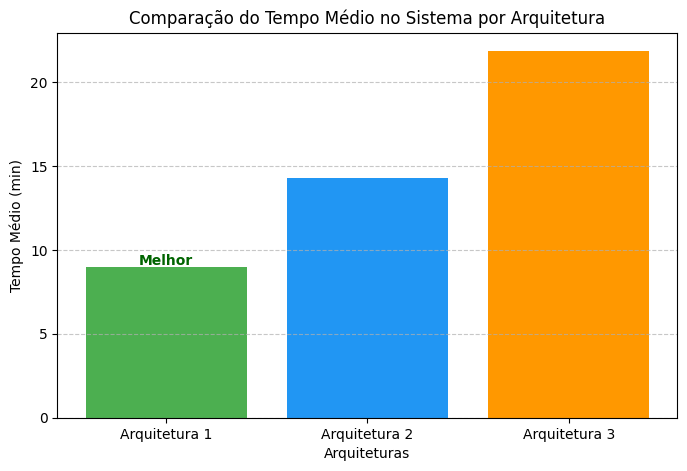

In [ ]:
# Comparar médias
comparacao = {
    "Arquitetura 1": df1["tempo_sistema"].mean(),
    "Arquitetura 2": df2["tempo_sistema"].mean(),
    "Arquitetura 3": df3["tempo_sistema"].mean(),
}

print("\n🏁 Comparação de desempenho (tempo médio no sistema):")
for k, v in comparacao.items():
    print(f"{k}: {v:.2f}")

melhor = min(comparacao, key=comparacao.get)
print(f"\n✅ Melhor arquitetura (menor tempo no sistema): {melhor}")

# ====== Gráfico comparativo ======
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.bar(comparacao.keys(), comparacao.values(), color=["#4CAF50", "#2196F3", "#FF9800"])
plt.title("Comparação do Tempo Médio no Sistema por Arquitetura")
plt.ylabel("Tempo Médio (min)")
plt.xlabel("Arquiteturas")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Destacar a melhor arquitetura
ymax = max(comparacao.values())
plt.text(melhor, comparacao[melhor] + 0.1, "Melhor", ha="center", color="darkgreen", fontweight="bold")

plt.show()
